# Demo for RFIW-2020 (Task 1): Kinship Verification
## Overview
This basic demo shows some tricks for using [pandas](https://pandas.pydata.org) in the Recognizing Families In 
the Wild (w[RFIW](https://web.northeastern.edu/smilelab/rfiw2020/)) data challenge. Specifically, kinship
verification ([Task-I](https://competitions.codalab.org/competitions/21843)).

We will evaluate pairs and perform analysis on the features used for assessment. Specifically, we will
- Load all features into dictionary.
- Evaluate according to verification protocol.
  - Calculate verification accuracies for the different relationship pair-types, along with the averaged accuracy.
  - Generate a ROC curve.
  - Visualize score distributions for KIN and NON-KIN for the different relationship types.


## Preparing Data
Features are assumed to  be extracted, stored as [pickles](https://docs.python.org/3/library/pickle.html), and 
saved with the same directory structure and naming scheme as the face images. Features are read in as a dictionary, with keys set as the relative file paths without file extensions (i.e., \<FID\>/\<MID\>/\<faceID\>). See [Prepare features](#Prepare-features)-- to change the i/o scheme modify the respective cell. For this, faces were encoded using ArcFace trained on MSCeleb in Pytorch (source, [Github](https://github.com/ronghuaiyang/arcface-pytorch)). However, any features can be plugged in.

No fine-tuning or special tricks were applied to the features. The purpose here is to demonstrate how to complete the evaluation in a few easy steps. Also, we see how to easily generate visualizations that are both appealing and insightful.

### Setup environment and set style for plots

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
%matplotlib inline
# set styles for figures
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('whitegrid', {'font.family': 'serif',
                            'font.serif' : 'Times New Roman', 'fontsize': 18})

### Prepare features

In [3]:
# here set the baths to pairs list, along with directory containing features
dir_data = '../../data/rfiw2020-data/verification/'
dir_val = dir_data + 'val-faces/'
dir_val_features = dir_val.replace('/val-faces/', '/val-features/')


Load pickle files and determine relationship types

In [4]:
# load pairs as DataFrame (from PKL file)
df_pairlist = pd.read_csv(dir_data + 'val-pairs.csv')
df_pairlist.ptype =df_pairlist.ptype.str.upper()   # set tags to uppercase for formatting later  

# get all unique relationship types in DF
relationship_types = df_pairlist.ptype.unique()

print('Processing {} pairs of {} relationship types'.format(len(df_pairlist), len(relationship_types)))
print(relationship_types)
df_pairlist.head()

FileNotFoundError: [Errno 2] File ../../data/rfiw2020-data/verification/val-pairs.csv does not exist: '../../data/rfiw2020-data/verification/val-pairs.csv'

### Build a list of all images in pairs list

In [ ]:
li_images = list(np.unique(df_pairlist.p1.to_list() + df_pairlist.p2.to_list()))
print(f"No. Images {len(li_images)}")

### load all features in LUT (ie dictionary)

In [ ]:
features = {f: pd.read_pickle(dir_val_features + f.replace('.jpg', '.pkl')) for f in
            li_images}

### Calculate cosine score for each pair

In [ ]:
# score all feature pairs, because L2 norm applied on features dot is same as cosine sim
df_pairlist['score'] = df_pairlist.apply(
    lambda x: np.dot(features[x.p1], features[x.p2].T), axis=1)

In [ ]:
df_pairlist.head()

In [ ]:
df_pairlist.tail()

The top of the table contains the positive pairs, while the bottom is the negatives. See the differences in scores. As we would hope, the KIN pairs seem to score higher (i.e., be more similar) than that of the NON-KIN.

# Measure Performance

In most cases, the labels get loaded from a separate file. However, here, we infer the tag as ‘KIN’ or ‘NON-KIN’ depending on whether or not the family ID (FID) of subjects 1 and 2.

In [9]:
df_pairlist['label'] = (df_pairlist.fid1 == df_pairlist.fid2).astype(np.uint)
# 'tags' column in for formatting legend in plots
df_pairlist['tags'] = 'KIN'
df_pairlist.loc[df_pairlist.label==0, 'tags'] = 'NON-KIN'

NameError: name 'df_pairlist' is not defined

### Generate ROC curve

In [10]:
fpr, tpr, threshold = roc_curve(df_pairlist.label.values,
                                df_pairlist.score.values)
auc = roc_auc_score(df_pairlist.label.values, df_pairlist.score.values)

NameError: name 'df_pairlist' is not defined

In [7]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (AUC: %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC: 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC All Types Averaged')
plt.legend(loc="best")

NameError: name 'fpr' is not defined

<Figure size 432x288 with 0 Axes>

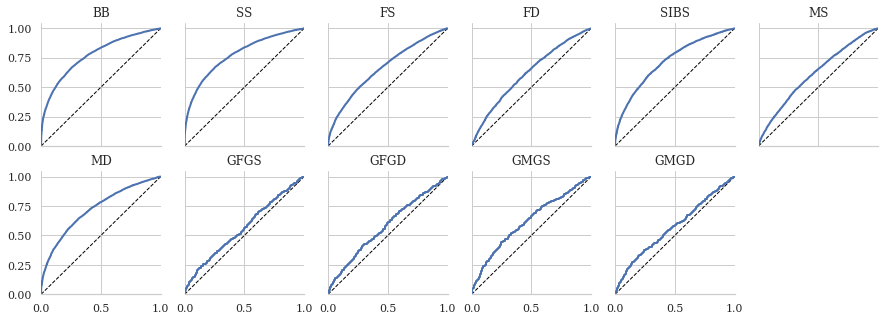

In [38]:

f, axs = plt.subplots(2, int(np.ceil(len(relationship_types)/2)),figsize=(15,5), sharex=True, sharey=True)
sns.despine(left=True)
i = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[0,5],[1,1],[1,2],[1,3],[1,4],[1,5]]
for j, att in enumerate(relationship_types):
    df_cur = df_pairlist.loc[df_pairlist.ptype == att,['score', 'label']]
    fpr, tpr, threshold = roc_curve(df_cur.label.values, df_cur.score.values)
    auc = roc_auc_score(df_cur.label.values, df_cur.score.values)
    axs[i[j][0],i[j][1]].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[i[j][0],i[j][1]].plot(fpr, tpr, lw=2, label='(AUC: {:.2})'.format(auc))
    axs[i[j][0],i[j][1]].set_xlim([0.0, 1.0])
    axs[i[j][0],i[j][1]].set_ylim([0.0, 1.05])
    axs[i[j][0],i[j][1]].set_title(f"{att}")
axs[-1,-1].set_axis_off()

The grandparent-grandchildren do not separate well provided the current settings. Let us do some analysis.

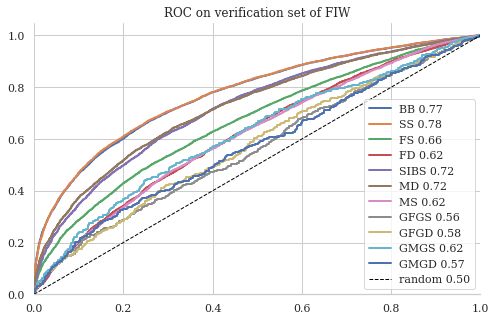

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine(left=True)
i = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[0,5],[1,1],[1,2],[1,3],[1,4],[1,5]]
for j, att in enumerate(relationship_types):
    df_cur = df_pairlist.loc[df_pairlist.ptype == att,['score', 'label']]
    fpr, tpr, threshold = roc_curve(df_cur.label.values, df_cur.score.values)
    auc = roc_auc_score(df_cur.label.values, df_cur.score.values)
    ax.plot(fpr, tpr, lw=2, label='{} {:.2}'.format(att, auc))
    
ax.set_xlim([0.0, 1.0])
ax.plot([0, 1], [0, 1], label='random 0.50', color='black', lw=1, linestyle='--')
ax.set_title(f"ROC on verification set of FIW")
ax.set_ylim([0.0, 1.05])
plt.legend(loc='best')

### Feature Analysis

Next, plot signal detection models (SDM) for each relationship type. From this, we view the distribution of scores as a function of the label (i.e., KIN vs. NON-KIN).


<Figure size 432x288 with 0 Axes>

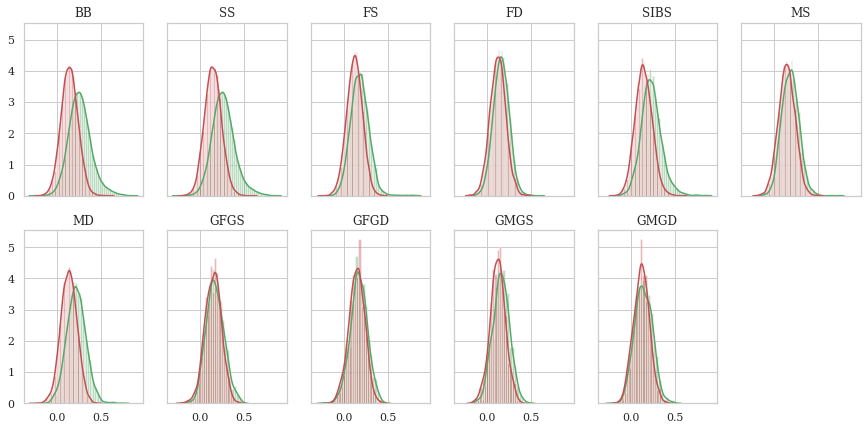

In [49]:
df_pairlist.label=df_pairlist.label.astype(int)

sns.despine(left=True)

f, axs = plt.subplots(2, int(np.ceil(len(relationship_types)/2)),figsize=(15,7), sharex=True, sharey=True)
i = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[0,5],[1,1],[1,2],[1,3],[1,4],[1,5]]
for j, att in enumerate(relationship_types):
    df_cur = df_pairlist.loc[df_pairlist.ptype == att,['score', 'label']]
    sns.distplot(df_cur.loc[df_cur.label==1,'score'],hist=True, label='True',ax=axs[i[j][0],i[j][1]],color='g')
    sns.distplot(df_cur.loc[df_cur.label==0,'score'], hist=True,label='False',ax=axs[i[j][0],i[j][1]],color='r')
    axs[i[j][0],i[j][1]].set_title(att)
    axs[i[j][0],i[j][1]].set_xlabel('')
axs[-1,-1].set_axis_off()

Similar to SDM, but let’s look at violin plots as means of another visualization of two-class separability.

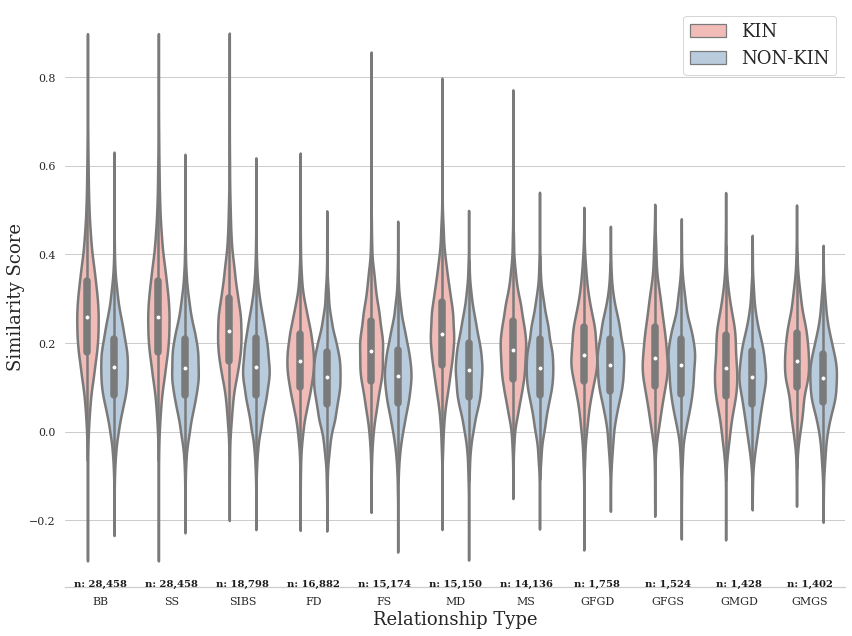

In [55]:
plt.close('all')
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
sns.despine(left=True)

sns.violinplot(x='ptype',y='score',data=df_pairlist,hue='tags', ax=ax, linewidth=2.5, width=0.75, palette="Pastel1",
               order=[ "BB", "SS", "SIBS", 'FD', 'FS', "MD", "MS",'GFGD','GFGS','GMGD', 'GMGS'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Relationship Type', fontsize=18)

ax.set_ylabel('Similarity Score', fontsize=18)
# Calculate number of obs per group & median to position labels
medians = df_pairlist.groupby(['ptype'])['score'].min().values
nobs = df_pairlist['ptype'].value_counts().values
nobs = [str(f'{x:,}') for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    value = pos[tick]
    ax.text(value, -0.35, nobs[tick], horizontalalignment='center', fontsize=18, size='small', color='k', weight='semibold')
    # ax.text(value, medians[tick] - medians[tick]*0.15, nobs[tick], horizontalalignment='center', size='x-small', color='k', weight='semibold')

plt.legend(loc="best", fontsize=18)
plt.tight_layout()